In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn as sk
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras as K
import xgboost as xg

import numpy as np
from numpy import random as rand
rand.seed(2442)

/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 1) Example de feature engineering

In [3]:
n_points = 1000000
angles = pd.Series(rand.uniform(0,2*np.pi,n_points),name="angle")
true_radius = pd.Series(rand.choice(range(0,10),n_points),name="true_radius")

circle_data = pd.DataFrame(zip(angles,true_radius),columns=["angle","true_radius"])
circle_data = circle_data.assign(radius=lambda x: rand.normal(x.true_radius, 0.4))

circle_data["target"] = circle_data["true_radius"].map(lambda x: np.rint(x)%2)
circle_data["x"] = circle_data["radius"] * np.cos(circle_data["angle"])
circle_data["y"] = circle_data["radius"] * np.sin(circle_data["angle"])
circle_data["z"] = rand.uniform(0,10,n_points)

/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


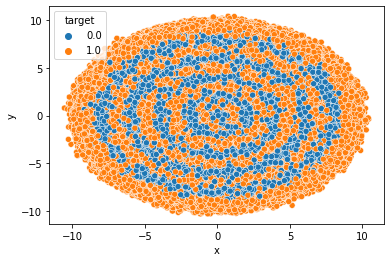

In [4]:
sns.scatterplot(x="x",y="y",data=circle_data,hue="target")
plt.show()

<AxesSubplot:xlabel='x', ylabel='reco_radius'>

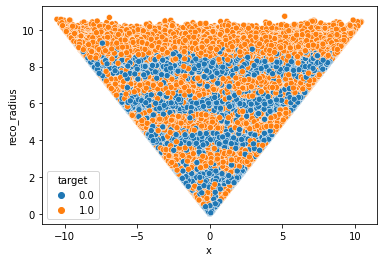

In [5]:
circle_data["reco_radius"] = np.sqrt(circle_data["x"]**2 + circle_data["y"]**2)
sns.scatterplot(data=circle_data,x="x",y="reco_radius",hue="target")

<AxesSubplot:xlabel='is_odd', ylabel='Count'>

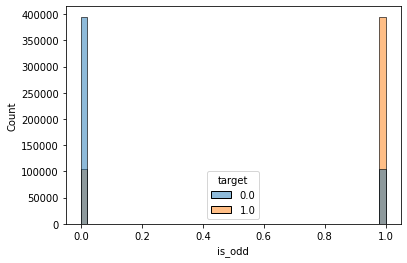

In [6]:
circle_data['is_odd'] = circle_data['reco_radius'].map(lambda x: np.rint(x)%2)
sns.histplot(data=circle_data,x="is_odd",hue="target")

In [7]:
metrics.accuracy_score(circle_data["target"],circle_data['is_odd'])

0.78894

# 2) Example over-fitting & underfitting

In [8]:
rand.seed(2442)

npoints=60
x = rand.normal(0,2,npoints)
y = 3*x+5*x**2-3*x**3+rand.normal(0,60,npoints)
y -= min(y)
y /= max(y)

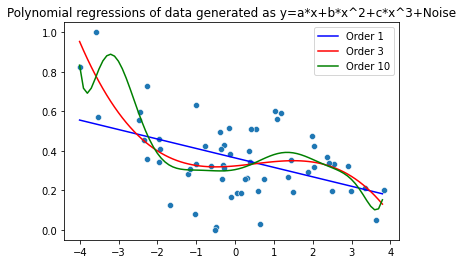

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def poly_reg(deg,x):
    poly_reg = PolynomialFeatures(degree=deg)
    X_poly = poly_reg.fit_transform(x.reshape(-1, 1))
    pol_reg = LinearRegression()
    pol_reg.fit(X_poly, y)
    return pol_reg,poly_reg

X_grid = np.arange(min(x), max(x), 0.1)
X_grid = X_grid.reshape(len(X_grid), 1) 

orders={
    1:'blue',
    3:'red',
    10:'green',
}

for id,val in orders.items():
    pol,poly = poly_reg(id,x)
    plt.plot(X_grid, pol.predict(poly.fit_transform(X_grid)), color=val,label=f"Order {id}")

sns.scatterplot(x=x,y=y)
plt.title("Polynomial regressions of data generated as y=a*x+b*x^2+c*x^3+Noise")
plt.show()

# 3) Example coefficient correlation

### 1 - Multivariate Gaussian

In [10]:
rand.seed(2442)

npoints=1000
# Moyennes :
m = np.array([-1,1,4])
# Matrice de correlation souhaitee
r = np.array(
    [
        [  1, 0.2, 0.5],
        [ 0.2,  1, 0.7],
        [ 0.5, 0.7, 1]
    ])
data_corr = pd.DataFrame(rand.multivariate_normal(m, r, size=npoints),columns=['x','y','z'])

Text(0.5, 1.0, 'Multi-variate gaussian model (2D proj)')

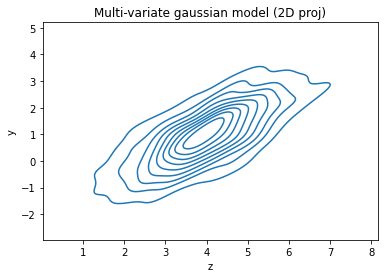

In [11]:
sns.kdeplot(x='z',y='y',data=data_corr)
plt.title("Multi-variate gaussian model (2D proj)")

Text(0.5, 1.0, 'Correlation plot for data generated according to multi-variate Gaussian')

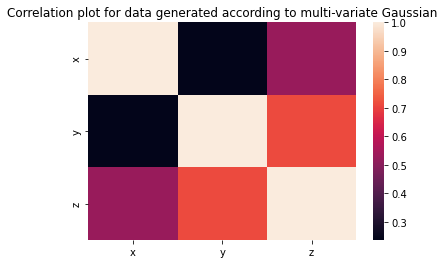

In [12]:
sns.heatmap(data_corr.corr())
plt.title("Correlation plot for data generated according to multi-variate Gaussian")

### 2 - Example where correlations doesn't show the relation & Mutual Information does

Let's take back the "circle" model we had before, and this time add an additional uniform dimension that's not linked to the target (z)

Text(0.5, 1.0, 'Correlation plot for data from the "circle" model')

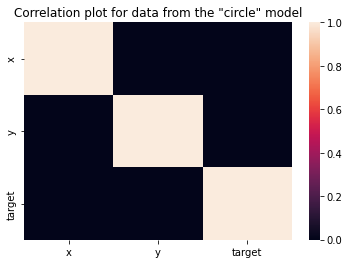

In [13]:
sns.heatmap(circle_data[["x","y","target"]].corr())
plt.title("Correlation plot for data from the \"circle\" model")

Text(0.5, 1.0, 'Mutual Information Scores for the "cylinder model" (circles model + uniform z)')

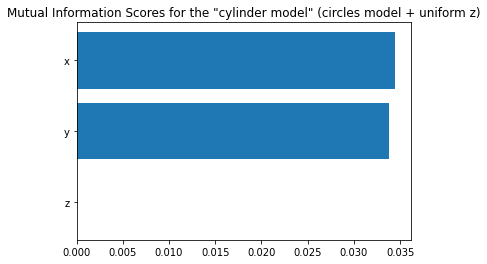

In [14]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y) #, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)

plot_mi_scores(make_mi_scores(circle_data[["x","y","z"]],circle_data["target"]))
plt.title("Mutual Information Scores for the \"cylinder model\" (circles model + uniform z)")

# 4) Example loss power in copper cable

Keep in mind : here I assess the performances on the same than the I trained on, which you should avoid !

As it was done for illustrative purposes it's more +/- fine

In [15]:
rand.seed(2442)

n_cables = 75000
current_density = 0.75 #A/mm^2

data_cable = pd.DataFrame()
data_cable['radius'] = rand.normal(13, 1.3, n_cables)
data_cable['length'] = rand.normal(3000, 3000*0.15, n_cables)
data_cable['resistivity'] = rand.normal(1.7*1e-5, 0.2*1.7*1e-5, n_cables)
data_cable = data_cable.assign(
    power=lambda x: np.pi * x.resistivity * x.length * (x.radius**2) * (current_density**2)
)

Text(0.5, 0, 'Puissance dissipee (en MW)')

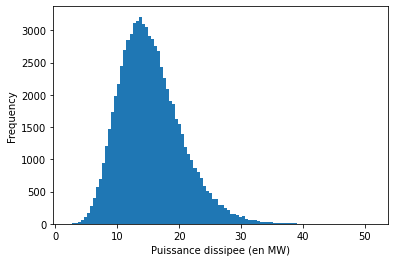

In [16]:
data_cable['power'].plot(kind='hist',bins=100)
plt.xlabel("Puissance dissipee (en MW)")

In [17]:
model = K.Sequential(
    [
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

2022-02-14 08:17:42.753410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-02-14 08:17:42.753457: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-14 08:17:42.757089: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2022-02-14 08:17:42.767773: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
74/74 [==============================] - 1s 1ms/step - loss: 21.6520 - mse: 21.6520
Epoch 2/20
74/74 [==============================] - 0s 872us/step - loss: 20.1817 - mse: 20.1817
Epoch 3/20
74/74 [==============================] - 0s 825us/step - loss: 20.1148 - mse: 20.1148
Epoch 4/20
74/74 [==============================] - 0s 836us/step - loss: 20.0479 - mse: 20.0479
Epoch 5/20
74/74 [==============================] - 0s 856us/step - loss: 19.9770 - mse: 19.9770
Epoch 6/20
74/74 [==============================] - 0s 856us/step - loss: 19.9488 - mse: 19.9488
Epoch 7/20
74/74 [==============================] - 0s 824us/step - loss: 19.8067 - mse: 19.8067
Epoch 8/20
74/74 [==============================] - 0s 895us/step - loss: 19.6940 - mse: 19.6940
Epoch 9/20
74/74 [==============================] - 0s 874us/step - loss: 19.6654 - mse: 19.6654
Epoch 10/20
74/74 [==============================] - 0s 859us/step - loss: 19.5730 - mse: 19.5730
Epoch 11/20
74/74 [============

In [18]:
res=model.predict(data_cable[["radius","length","resistivity"]])
res=res[:,0]-data_cable["power"]
res /= data_cable["power"]

10.942774178028746 34.368138707056495


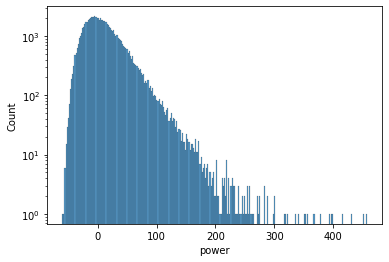

In [19]:
sns.histplot(100*res)
plt.yscale('log')
print(f"{np.mean(100*res)} {np.std(100*res)}")

In [20]:
model = K.Sequential(
    [
        K.layers.BatchNormalization(),
        K.layers.Dense(6, activation="relu", name="layer1"),
        K.layers.Dense(6, activation="relu", name="layer2"),
        K.layers.Dense(6, activation="relu", name="layer3"),
        K.layers.Dense(6, activation="relu", name="layer4"),
        K.layers.Dense(1, name="layer5")
    ]
)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.fit(data_cable[["radius","length","resistivity"]], data_cable[["power"]], epochs=20, batch_size=1024)

res2=model.predict(data_cable[["radius","length","resistivity"]])
res2=res2[:,0]-data_cable["power"]
res2 /= data_cable["power"]

Epoch 1/20
74/74 [==============================] - 0s 1ms/step - loss: 258.1866 - mse: 258.1866
Epoch 2/20
74/74 [==============================] - 0s 927us/step - loss: 232.4473 - mse: 232.4473
Epoch 3/20
74/74 [==============================] - 0s 952us/step - loss: 146.8815 - mse: 146.8815
Epoch 4/20
74/74 [==============================] - 0s 945us/step - loss: 60.8417 - mse: 60.8417
Epoch 5/20
74/74 [==============================] - 0s 942us/step - loss: 23.1031 - mse: 23.1031
Epoch 6/20
74/74 [==============================] - 0s 935us/step - loss: 13.3442 - mse: 13.3442
Epoch 7/20
74/74 [==============================] - 0s 946us/step - loss: 11.6644 - mse: 11.6644
Epoch 8/20
74/74 [==============================] - 0s 937us/step - loss: 11.1661 - mse: 11.1661
Epoch 9/20
74/74 [==============================] - 0s 930us/step - loss: 10.9512 - mse: 10.9512
Epoch 10/20
74/74 [==============================] - 0s 921us/step - loss: 10.8470 - mse: 10.8470
Epoch 11/20
74/74 [======

4.314121454601547 25.050684384298854


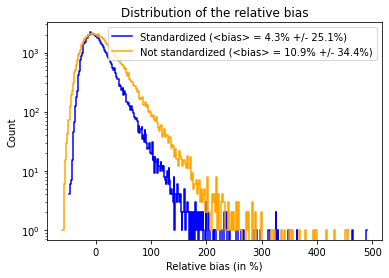

In [21]:
sns.histplot(100*res2,element='step',color='blue',label=f"Standardized (<bias> = {np.mean(100*res2):.1f}% +/- {np.std(100*res2):.1f}%)",fill=False)
sns.histplot(100*res,element='step',color='orange',label=f"Not standardized (<bias> = {np.mean(100*res):.1f}% +/- {np.std(100*res):.1f}%)",fill=False)
plt.yscale('log')
plt.legend()
plt.xlabel('Relative bias (in %)')
plt.title("Distribution of the relative bias")
print(f"{np.mean(100*res2)} {np.std(100*res2)}")

# 5) Example K-Means

In [22]:
rand.seed(2442)

true_nclus = rand.choice(range(4,8))
clus_range = range(true_nclus)

un=lambda: rand.uniform(-10,10)
gs=lambda x: rand.normal(x,2)

centroids = [np.array([un(), un()]) for i in clus_range]
covars = [np.diag([gs(1.5),gs(2)]) for i in clus_range]
npoints= [np.rint(np.abs(rand.normal(2500,2000))) for i in clus_range]

tmp = [
    pd.DataFrame(rand.multivariate_normal(centroids[i], covars[i], size=int(npoints[i])), columns=['x','y'])
    for i in range(true_nclus) 
]
for i in range(len(tmp)): 
    tmp[i]['true_cluster'] = i

data_clustering = pd.concat(tmp)

/tmp/ipykernel_16/3203182361.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  pd.DataFrame(rand.multivariate_normal(centroids[i], covars[i], size=int(npoints[i])), columns=['x','y'])


Text(0.5, 1.0, 'Distribution of generated data, colored by the cluster they truly belong to')

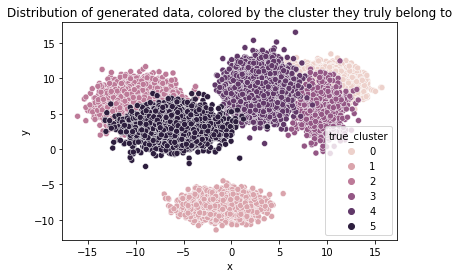

In [23]:
sns.scatterplot(data=data_clustering, x='x', y='y', hue='true_cluster')
plt.title('Distribution of generated data, colored by the cluster they truly belong to')

Text(0.5, 1.0, 'Distribution of generated data, colored by the clusters KMeans (N=6) attach them to')

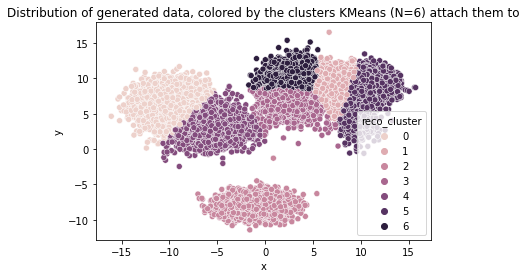

In [24]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=7, random_state=2442).fit(data_clustering[ ['x','y'] ])
data_clustering['reco_cluster'] = kmeans.predict(data_clustering[ ['x','y'] ])

sns.scatterplot(data=data_clustering, x='x', y='y', hue='reco_cluster')
plt.title('Distribution of generated data, colored by the clusters KMeans (N=6) attach them to')

# 6) Example Principal Compenent Analysis

In [25]:
from sklearn.decomposition import PCA
rand.seed(2442)

In [26]:
tmp = rand.rand(25,25)
cov = np.dot(tmp, tmp.transpose())
means = rand.uniform(-2,2,25)
data_pca = pd.DataFrame(rand.multivariate_normal(means, cov, size=1000000))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='0', ylabel='1'>

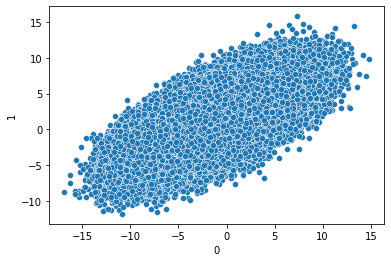

In [27]:
sns.scatterplot(data_pca[0],data_pca[1])

In [28]:
pca = PCA().fit(data_pca)

<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>

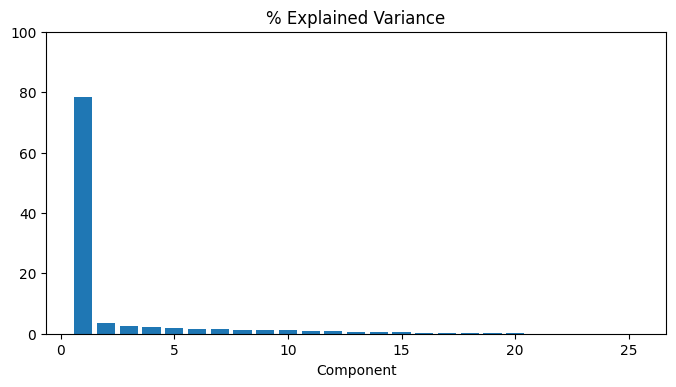

In [29]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 1)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = 100*pca.explained_variance_ratio_
    axs.bar(grid, evr)
    axs.set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 100.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

# 7) Example training history

In [57]:
rand.seed(2442)

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split 

In [58]:
train_X, test_X, train_y, test_y = train_test_split(data_cable[["radius","length","resistivity"]],data_cable["power"])
eval_set = [(train_X, train_y), (test_X, test_y)]

xreg=XGBRegressor(n_estimators=1000)
xreg.fit(train_X,train_y, eval_set=eval_set, eval_metric=["rmse"], verbose=False)

/usr/local/lib/python3.8/dist-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [52]:
from sklearn.metrics import mean_squared_error
mean_squared_error(xreg.predict(test_X),test_y)

0.03697087667531932

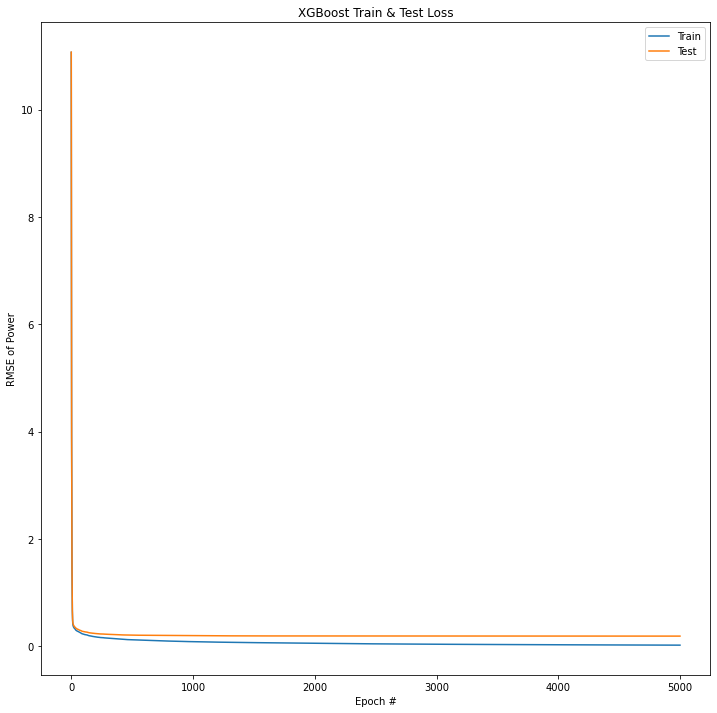

In [53]:
results = xreg.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results["validation_0"]["rmse"], label="Train")
ax.plot(x_axis, results["validation_1"]["rmse"], label="Test")
ax.legend()
plt.ylabel("RMSE of Power")
plt.xlabel("Epoch #")
plt.title("XGBoost Train & Test Loss")
plt.show()